In [1]:
import os

import pandas as pd
import numpy as np
from numpy import savetxt

import keras 
from keras.models import Sequential
from keras.layers import Activation 
from keras.layers.core import Dense 
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from keras.metrics import binary_crossentropy
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint


%matplotlib inline
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import itertools
import matplotlib.pyplot as plt

import random as rn

from google.colab import drive
from google.colab import files

In [2]:
seed = 17
np.random.seed (seed)
rn.seed (seed)

In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# Initial data preparation 

!unzip "/content/gdrive/My Drive/gearboxdata.zip"

Archive:  /content/gdrive/My Drive/gearboxdata.zip
   creating: gearboxdata/
   creating: gearboxdata/BrokenTooth Data/
  inflating: gearboxdata/BrokenTooth Data/Broken(1).csv  
  inflating: gearboxdata/BrokenTooth Data/Broken(10).csv  
  inflating: gearboxdata/BrokenTooth Data/Broken(2).csv  
  inflating: gearboxdata/BrokenTooth Data/Broken(3).csv  
  inflating: gearboxdata/BrokenTooth Data/Broken(4).csv  
  inflating: gearboxdata/BrokenTooth Data/Broken(5).csv  
  inflating: gearboxdata/BrokenTooth Data/Broken(6).csv  
  inflating: gearboxdata/BrokenTooth Data/Broken(7).csv  
  inflating: gearboxdata/BrokenTooth Data/Broken(8).csv  
  inflating: gearboxdata/BrokenTooth Data/Broken(9).csv  
   creating: gearboxdata/Healthy Data/
  inflating: gearboxdata/Healthy Data/Healthy(1).csv  
  inflating: gearboxdata/Healthy Data/Healthy(10).csv  
  inflating: gearboxdata/Healthy Data/Healthy(2).csv  
  inflating: gearboxdata/Healthy Data/Healthy(3).csv  
  inflating: gearboxdata/Healthy Data/H

In [5]:
# Initial data preparation for healthy data 

Healthy = np.random.rand(10,80000,4)
Labels_Healthy = np.zeros(10)

for i in range (10): 
  reader = pd.read_csv('gearboxdata/Healthy Data/Healthy(%s).csv' %(i+1), header=None) 
  reader = pd.DataFrame.to_numpy(reader)
  
  #Normalizing each column of data
  for j in range (4):
    reader[:,j] = (reader[:,j] - reader[:,j].min(axis=0)) / (reader[:,j].max(axis=0) - reader[:,j].min(axis=0))


  Healthy[i,:] = reader[:80000]

# Initial data preparation for broken data 

Broken = np.random.rand(10,80000,4)
Labels_Broken = np.ones(10)

for i in range (10): 
  reader = pd.read_csv('gearboxdata/BrokenTooth Data/Broken(%s).csv' %(i+1), header=None) 
  reader = pd.DataFrame.to_numpy(reader)
  
  #Normalizing each column of data
  for j in range (4):
    reader[:,j] = (reader[:,j] - reader[:,j].min(axis=0)) / (reader[:,j].max(axis=0) - reader[:,j].min(axis=0))


Broken[i,:] = reader[:80000]

[Text(0, 0.5, 'Sensor4')]

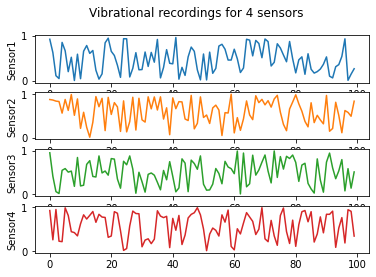

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4)
fig.suptitle('Vibrational recordings for 4 sensors')
ax1.plot(Broken[0,0:100,0])
ax1.set(ylabel='Sensor1')
ax2.plot(Broken[0,0:100,1],'tab:orange') 
ax2.set(ylabel='Sensor2')
ax3.plot(Broken[0,0:100,2],'tab:green')
ax3.set(ylabel='Sensor3')
ax4.plot(Broken[0,0:100,3],'tab:red') 
ax4.set(ylabel='Sensor4')

In [6]:
Features = np.concatenate((Healthy,Broken), axis=0)
Labels = np.concatenate((Labels_Healthy,Labels_Broken), axis=0)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(Features, Labels, test_size=0.3)

In [8]:
windows_size = 25
Nsensors = 4
input_dimension = windows_size * Nsensors

ANN = Sequential([                 
    
    Dropout(0.2, input_shape=(input_dimension,)),       
    Dense(3, activation='relu'),
    Dense(1, activation='sigmoid')     
])

In [9]:
ANN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 303       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 4         
Total params: 307
Trainable params: 307
Non-trainable params: 0
_________________________________________________________________


In [10]:
ANN.compile(Adam(lr=.0001),loss='binary_crossentropy',metrics=['accuracy'])

#keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-6)
# Configurations: Adam(lr=.0001),optimizer='rmsprop', loss='sparse_categorical_crossentropy' loss='binary_crossentropy'

In [11]:
# checkpoint for finding the best performance 

filepath="weights.best.hdf5" 
checkpoint = ModelCheckpoint(filepath, monitor='loss' , verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [12]:
XX = np.random.rand(len(X_train),input_dimension)

step = 15
Niterations = 2000     # Maximum 2000 
Total_loop = 5        # This loop iterates through the whole signal
index = 0

for k in range (Total_loop):  
  X_train, X_test, y_train, y_test = train_test_split(Features, Labels, test_size=0.3)   #This shuffles the data for 5-fold cross-validation
  for j in range (Niterations):
    for i in range (len(X_train)):
      M_i = np.concatenate((X_train[i,index:windows_size+index,0],
                              X_train[i,index:windows_size+index,1],
                                X_train[i,index:windows_size+index,2],X_train[i,index:windows_size+index,3]), axis=0)
      XX[i,:] = M_i.T 

    
    history = ANN.fit(XX, y_train, validation_split=0.0, batch_size=5, epochs=1000, shuffle=True, callbacks=callbacks_list, verbose=2)
    i = 0
    index = (windows_size + step)*(j+1)
  index = 0
  j = 0

Streaming output truncated to the last 5000 lines.
Epoch 751/1000
3/3 - 0s - loss: 0.4673 - accuracy: 0.6429

Epoch 00751: loss did not improve from 0.17138
Epoch 752/1000
3/3 - 0s - loss: 0.3763 - accuracy: 0.9286

Epoch 00752: loss did not improve from 0.17138
Epoch 753/1000
3/3 - 0s - loss: 0.3941 - accuracy: 0.8571

Epoch 00753: loss did not improve from 0.17138
Epoch 754/1000
3/3 - 0s - loss: 0.2956 - accuracy: 0.9286

Epoch 00754: loss did not improve from 0.17138
Epoch 755/1000
3/3 - 0s - loss: 0.4075 - accuracy: 0.8571

Epoch 00755: loss did not improve from 0.17138
Epoch 756/1000
3/3 - 0s - loss: 0.3450 - accuracy: 0.9286

Epoch 00756: loss did not improve from 0.17138
Epoch 757/1000
3/3 - 0s - loss: 0.2784 - accuracy: 0.9286

Epoch 00757: loss did not improve from 0.17138
Epoch 758/1000
3/3 - 0s - loss: 0.3377 - accuracy: 0.9286

Epoch 00758: loss did not improve from 0.17138
Epoch 759/1000
3/3 - 0s - loss: 0.2096 - accuracy: 1.0000

Epoch 00759: loss did not improve from 0.1

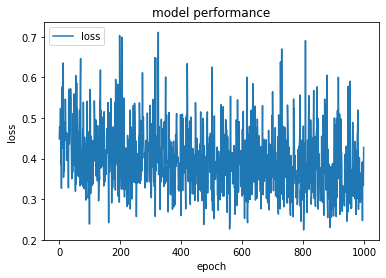

In [13]:
# summarize history for accuracy or loss

#plt.plot(history.history['accuracy']) 
plt.plot(history.history['loss']) 
plt.title('model performance') 
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend(['loss'], loc='upper left') 
plt.show()

In [64]:
ANN.load_weights("weights.best.hdf5")

In [71]:
index = 0
step = 15
Performance = 0
N_test_iterations = 2000    # Maximum equals to Niterations (2000)
i = j = 0 
RP = np.random.rand(len(X_test),)

XX_test = np.random.rand(len(X_test),input_dimension)
Evaluation_records = np.random.rand(N_test_iterations)

Network_cm = np.random.rand(2,2)
Performance_cm = np.zeros((2, 2))
Evaluation_cm = np.random.rand(N_test_iterations,2,2)

for j in range (N_test_iterations):
  for i in range (len(X_test)):
    M_i = np.concatenate((X_test[i,index:windows_size+index,0],
                            X_test[i,index:windows_size+index,1],
                              X_test[i,index:windows_size+index,2],X_test[i,index:windows_size+index,3]), axis=0)
    XX_test[i,:] = M_i.T 

  
  TT = ANN.predict(XX_test, verbose=0)       #This customized thresholder works better at 0.15 step
  for i in range (len(X_test)):
    if (TT[i,]<0.3):
      RP[i,] = 0
    else:
      RP[i,] = 1 
  Network_Performance = np.mean(y_test==RP)
  Performance += Network_Performance 
  Evaluation_records[j,] = Network_Performance 

  Network_cm = confusion_matrix(y_test, RP)
  Performance_cm = np.add(Performance_cm, Network_cm) 
  Evaluation_cm[j,] = Network_cm

  index = (windows_size + step)*(j+1)

Final_accuracy = (Performance/N_test_iterations)*100
Final_cm = Performance_cm     #(Performance_cm/N_test_iterations)

Accuracy = (Final_cm[0,0]+Final_cm[1,1])/(Final_cm[0,0]+Final_cm[1,1]+Final_cm[1,0]+Final_cm[0,1])
Sensitivity = Final_cm[1,1]/(Final_cm[1,0]+Final_cm[1,1]) 
Specificity = Final_cm[0,0]/(Final_cm[0,0]+Final_cm[0,1]) 
Precision = Final_cm[1,1]/(Final_cm[0,1]+Final_cm[1,1]) 
print("Confusion Matrix:\n", Final_cm)
print("Accuracy:", Accuracy)
print("Sensitivity:", Sensitivity)
print("Specificity:", Specificity)
print("Precision:", Precision)

Confusion Matrix:
 [[7424.  576.]
 [1440. 2560.]]
Accuracy: 0.832
Sensitivity: 0.64
Specificity: 0.928
Precision: 0.8163265306122449


In [ ]:
print(Evaluation_records.shape)
print(Evaluation_records[1900:2000])

In [35]:
def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    print(cm)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment='center',
                color='white' if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('Actual Labels')
    plt.xlabel('Neural Network Prediction')

Confusion matrix, without normalization
[[7424.  576.]
 [1440. 2560.]]


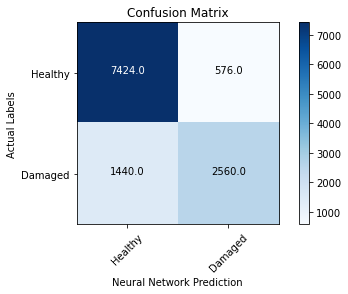

In [72]:
cm_plot_labels = ['Healthy', 'Damaged']
plot_confusion_matrix(Final_cm, cm_plot_labels, title='Confusion Matrix')

In [73]:
#Download trained network parameters for conversion

ANN.save_weights('ERTIS_weights.h5')
ANN.save('ERTIS_example_model.h5')
files.download('ERTIS_weights.h5')

weight_Analog = ANN.get_weights()
np.savetxt('weight_Analog.txt' , weight_Analog , fmt='%s', delimiter=',')
files.download('weight_Analog.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Upload trained network parameters 

uploaded = files.upload()
ANN.load_weights('ERTIS_weights.h5')

Saving ERTIS_weights.h5 to ERTIS_weights (2).h5


In [74]:
# Network parameters in analog values

ANN.get_weights()

[array([[-0.17351541,  0.16027707,  0.09162102],
        [ 0.11238021, -0.23771665, -0.3142828 ],
        [-0.21777295, -0.02621966, -0.3955897 ],
        [-0.12552543, -0.01694564,  0.42667603],
        [ 0.17739934, -0.14962889, -0.05646145],
        [-0.22977221, -0.23752347,  0.06101323],
        [ 0.08283619,  0.11227882,  0.28712642],
        [ 0.1301323 ,  0.06882042, -0.14665808],
        [-0.00757428, -0.18421957, -0.35082555],
        [ 0.10170429,  0.29292798, -0.14179146],
        [-0.24572001,  0.05699625, -0.22848389],
        [-0.17130417, -0.1815066 , -0.00464166],
        [-0.00213777, -0.0283251 , -0.02178723],
        [ 0.12378835,  0.08569308,  0.12625   ],
        [-0.17114048, -0.24556148,  0.09521911],
        [ 0.2063539 , -0.08301243, -0.13359763],
        [ 0.1090852 ,  0.10062934,  0.2520683 ],
        [ 0.03582771,  0.4541043 , -0.1794274 ],
        [ 0.09494395,  0.03531691, -0.18621497],
        [-0.20365079, -0.11016587, -0.04458172],
        [-0.24246237

In [75]:
# Extraction of network weights and biases for 10-level conversion 

p_1 = ANN.layers[1].weights
w_1 = np.array(p_1[0])
b_1 = np.array(p_1[1])

p_2 = ANN.layers[2].weights
w_2 = np.array(p_2[0])
b_2 = np.array(p_2[1])

x= w_1
x2 = w_2

bias= b_1
bias2= b_2

In [76]:
# Here we calculate the absolute maximum weight/synaptic value in our network and the thresholding steps
# For layer number 1 

Absolute_Max_1 = np.max(abs(x))

if (Absolute_Max_1 < np.max(abs(bias))):
  Absolute_Max_1 = np.max(abs(bias))

step_1 = Absolute_Max_1/5
print(Absolute_Max_1)
print(step_1)

0.63561183
0.12712236642837524


In [77]:
# Here we calculate the absolute maximum weight/synaptic value in our network and the thresholding steps
# For layer number 2 

Absolute_Max_2 = np.max(abs(x2))

if (Absolute_Max_2 < np.max(abs(bias2))):
  Absolute_Max_2 = np.max(abs(bias2))

step_2 = Absolute_Max_2/5
print(Absolute_Max_2)
print(step_2)

1.6242856
0.32485711574554443


In [78]:
# Calculating the 10-bit resolution thresholds
# For layer 1: 

print('here are the thresholds for positive 5-bit:')
print (step_1)
print (2*step_1)
print (3*step_1)
print (4*step_1)
print (5*step_1)

stepn_1 = -1*step_1
print('here are the thresholds for negative 5-bit:')
print (stepn_1)
print (2*stepn_1)
print (3*stepn_1)
print (4*stepn_1)
print (5*stepn_1)

here are the thresholds for positive 5-bit:
0.12712236642837524
0.2542447328567505
0.3813670992851257
0.508489465713501
0.6356118321418762
here are the thresholds for negative 5-bit:
-0.12712236642837524
-0.2542447328567505
-0.3813670992851257
-0.508489465713501
-0.6356118321418762


In [79]:
#  10-bit thresholding (5 for positive and 5 for negative values)
#Layer 1: 

stepn_1 = -1*step_1

for i in range (100): 
  for j in range (3):
    if (0 < x[i,j] < step_1):
      x[i,j] = step_1
    elif (step_1 < x[i,j] < 2*step_1):
      x[i,j] = 2*step_1
    elif (2*step_1 < x[i,j] < 3*step_1):
      x[i,j] = 3*step_1
    elif (3*step_1 < x[i,j] < 4*step_1):
      x[i,j] = 4*step_1
    elif (4*step_1 < x[i,j]):
      x[i,j] = 5*step_1
    elif (stepn_1 < x[i,j] < 0):
      x[i,j] = stepn_1
    elif (2*stepn_1 < x[i,j] < stepn_1):
      x[i,j] = 2*stepn_1
    elif (3*stepn_1 < x[i,j] < 2*stepn_1):
      x[i,j] = 3*stepn_1
    elif (4*stepn_1 < x[i,j] < 3*stepn_1):
      x[i,j] = 4*stepn_1
    elif (x[i,j] < 4*stepn_1):
      x[i,j] = 5*stepn_1

#print(x)

# 10-bit thresholding for biases
i =0 

for i in range (3):
  if (0 < bias[i,] < step_1):
      bias[i,] = step_1
  elif (step_1 < bias[i,] < 2*step_1):
      bias[i,] = 2*step_1
  elif (2*step_1 < bias[i,] < 3*step_1):
      bias[i,] = 3*step_1
  elif (3*step_1 < bias[i,] < 4*step_1):
      bias[i,] = 4*step_1
  elif (4*step_1 < bias[i,]):
      bias[i,] = 5*step_1
  elif (stepn_1 < bias[i,] < 0):
      bias[i,] = stepn_1
  elif (2*stepn_1 < bias[i,] < stepn_1):
      bias[i,] = 2*stepn_1
  elif (3*stepn_1 < bias[i,] < 2*stepn_1):
      bias[i,] = 3*stepn_1
  elif (4*stepn_1 < bias[i,] < 3*stepn_1):
      bias[i,] = 4*stepn_1
  elif (bias[i,] < 4*stepn_1):
      bias[i,] = 5*stepn_1

#print(bias)

In [80]:
#  10-bit thresholding (5 for positive and 5 for negative values)
#Layer 2: 

stepn_2 = -1*step_2

for i in range (3): 
  for j in range (1):
    if (0 < x2[i,j] < step_2):
      x2[i,j] = step_2
    elif (step_2 < x2[i,j] < 2*step_2):
      x2[i,j] = 2*step_2
    elif (2*step_2 < x2[i,j] < 3*step_2):
      x2[i,j] = 3*step_2
    elif (3*step_2 < x2[i,j] < 4*step_2):
      x2[i,j] = 4*step_2
    elif (4*step_2 < x2[i,j]):
      x2[i,j] = 5*step_2
    elif (stepn_2 < x2[i,j] < 0):
      x2[i,j] = stepn_2
    elif (2*stepn_2 < x2[i,j] < stepn_2):
      x2[i,j] = 2*stepn_2
    elif (3*stepn_2 < x2[i,j] < 2*stepn_2):
      x2[i,j] = 3*stepn_2
    elif (4*stepn_2 < x2[i,j] < 3*stepn_2):
      x2[i,j] = 4*stepn_2
    elif (x2[i,j] < 4*stepn_2):
      x2[i,j] = 5*stepn_2

#print(x2)

i=0

for i in range (1):
  if (0 < bias2[i,] < step_2):
      bias2[i,] = step_2
  elif (step_2 < bias2[i,] < 2*step_2):
      bias2[i,] = 2*step_2
  elif (2*step_2 < bias2[i,] < 3*step_2):
      bias2[i,] = 3*step_2
  elif (3*step_2 < bias2[i,] < 4*step_2):
      bias2[i,] = 4*step_2
  elif (4*step_2 < bias2[i,]):
      bias2[i,] = 5*step_2
  elif (stepn_2 < bias2[i,] < 0):
      bias2[i,] = stepn_2
  elif (2*stepn_2 < bias2[i,] < stepn_2):
      bias2[i,] = 2*stepn_2
  elif (3*stepn_2 < bias2[i,] < 2*stepn_2):
      bias2[i,] = 3*stepn_2
  elif (4*stepn_2 < bias2[i,] < 3*stepn_2):
      bias2[i,] = 4*stepn_2
  elif (bias2[i,] < 4*stepn_2):
      bias2[i,] = 5*stepn_2 

#print (bias2)

In [81]:
# Evaluating the model with 10-bit resolution 
ANN_10 = Sequential([                 
    Dense(3, activation='relu',input_shape=(input_dimension,)),
    Dense(1, activation='sigmoid')     
])

ANN_10.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])

In [82]:
# Updating model topology based on calculated 10-bit parameters 

l=[]
l.append(x)
l.append(bias)
ANN_10.layers[0].set_weights(l)

l2=[]
l2.append(x2)
l2.append(bias2)
ANN_10.layers[1].set_weights(l2)

In [83]:
# Network parameters after 10-level conversion 

ANN_10.get_weights() 

[array([[-0.25424474,  0.25424474,  0.12712237],
        [ 0.12712237, -0.25424474, -0.3813671 ],
        [-0.25424474, -0.12712237, -0.5084895 ],
        [-0.12712237, -0.12712237,  0.5084895 ],
        [ 0.25424474, -0.25424474, -0.12712237],
        [-0.25424474, -0.25424474,  0.12712237],
        [ 0.12712237,  0.12712237,  0.3813671 ],
        [ 0.25424474,  0.12712237, -0.25424474],
        [-0.12712237, -0.25424474, -0.3813671 ],
        [ 0.12712237,  0.3813671 , -0.25424474],
        [-0.25424474,  0.12712237, -0.25424474],
        [-0.25424474, -0.25424474, -0.12712237],
        [-0.12712237, -0.12712237, -0.12712237],
        [ 0.12712237,  0.12712237,  0.12712237],
        [-0.25424474, -0.25424474,  0.12712237],
        [ 0.25424474, -0.12712237, -0.25424474],
        [ 0.12712237,  0.12712237,  0.25424474],
        [ 0.12712237,  0.5084895 , -0.25424474],
        [ 0.12712237,  0.12712237, -0.25424474],
        [-0.25424474, -0.12712237, -0.12712237],
        [-0.25424474

In [105]:
XX_test = np.random.rand(len(X_test),input_dimension)
Evaluation_records_10 = np.random.rand(N_test_iterations)

Network_cm_10 = np.random.rand(2,2)
Performance_cm_10 = np.zeros((2, 2))
Evaluation_cm_10 = np.random.rand(N_test_iterations,2,2)

RP_10 = np.random.rand(len(X_test),)

index = 0
Performance_10 = 0
N_test_iterations = 2000    # Maximum equals to Niterations
step = 15
i = 0
j= 0 

for j in range (N_test_iterations):
  for i in range (len(X_test)):
    M_i = np.concatenate((X_test[i,index:windows_size+index,0],
                            X_test[i,index:windows_size+index,1],
                              X_test[i,index:windows_size+index,2],X_test[i,index:windows_size+index,3]), axis=0)
    XX_test[i,:] = M_i.T 
    
  #rounded_predictions = ANN.predict_classes(XX_test, batch_size=5, verbose=0)
  TT_10 = ANN_10.predict(XX_test, verbose=0)       #This customized thresholder works better at 0.15 step
  for i in range (len(X_test)):
    if (TT_10[i,]<0.45):
      RP_10[i,] = 0
    else:
      RP_10[i,] = 1 
  Network_Performance_10 = np.mean(y_test==RP_10)
  Performance_10 += Network_Performance_10 
  Evaluation_records_10[j,] = Network_Performance_10 

  Network_cm_10 = confusion_matrix(y_test, RP_10)
  Performance_cm_10 = np.add(Performance_cm_10, Network_cm_10) 
  Evaluation_cm_10[j,] = Network_cm_10

  #Uncomment below codes for extracting the validation dataset and labels
  #np.savetxt('test_data(%s).csv' %(j+1) , XX_test , fmt='%1.2f', delimiter=',')
  #np.savetxt('test_labels(%s).csv' %(j+1) , y_test , fmt='%1.2f', delimiter=',')
  #files.download('test_data(%s).csv' %(j+1))
  #files.download('test_labels(%s).csv' %(j+1))

  index = (windows_size + step)*(j+1)

Final_accuracy_10 = (Performance_10/N_test_iterations)*100
Final_cm_10 = Performance_cm_10     #(Performance_cm_10/N_test_iterations)
Accuracy_10 = (Final_cm_10[0,0]+Final_cm_10[1,1])/(Final_cm_10[0,0]+Final_cm_10[1,1]+Final_cm_10[1,0]+Final_cm_10[0,1])
Sensitivity_10 = Final_cm_10[1,1]/(Final_cm_10[1,0]+Final_cm_10[1,1]) 
Specificity_10 = Final_cm_10[0,0]/(Final_cm_10[0,0]+Final_cm_10[0,1]) 
Precision_10 = Final_cm_10[1,1]/(Final_cm_10[0,1]+Final_cm_10[1,1]) 
print("Confusion Matrix:\n", Final_cm_10)
print("Accuracy:", Accuracy_10)
print("Sensitivity:", Sensitivity_10)
print("Specificity:", Specificity_10)
print("Precision:", Precision_10)

Confusion Matrix:
 [[7419.  581.]
 [1837. 2163.]]
Accuracy: 0.7985
Sensitivity: 0.54075
Specificity: 0.927375
Precision: 0.7882653061224489


Confusion matrix, without normalization
[[7419.  581.]
 [1837. 2163.]]


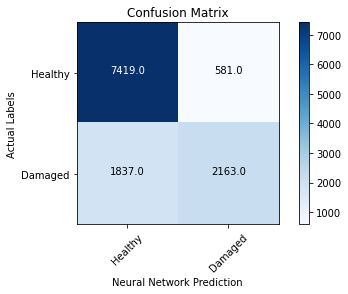

In [106]:
cm_plot_labels = ['Healthy', 'Damaged']
plot_confusion_matrix(Final_cm_10, cm_plot_labels, title='Confusion Matrix')

In [107]:
# Trained network parameters/weights extraction for the hardware deployment

weight_10level = ANN_10.get_weights()
np.savetxt('weight_10level.txt' , weight_10level , fmt='%s', delimiter=',')
files.download('weight_10level.txt')

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>